## 1. Import Necessary Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, Image
from imutils.contours import sort_contours
import os
import cv2
import imutils
import matplotlib.pyplot as plt
from string import ascii_uppercase, ascii_lowercase, digits
from sklearn.model_selection import train_test_split

In [ ]:
# CPU Optimizations 
tf.config.experimental.set_virtual_device_configuration(
    tf.config.experimental.list_physical_devices('CPU')[0],
    [tf.config.experimental.VirtualDeviceConfiguration()],
)

# GPU Memory Limit Optimization
tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices('GPU')[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=5799)],
)

## 2. Load Dataset

In [3]:
df  = pd.read_csv("data/English Typed Alphabets and Numbers Dataset in CSV/typedCSV.csv")
df

,label,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,...,pixel 774,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783
0,0,255,255,255,255,255,255,255,255,253,...,250,255,255,251,255,255,255,255,255,255
1,0,255,255,255,255,255,255,255,255,255,...,254,255,255,255,249,253,255,255,255,255
2,0,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,255,255
3,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,0,255,253,255,253,251,255,254,255,255,...,255,255,253,253,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62987,61,255,252,254,255,253,255,255,253,255,...,246,255,252,255,252,255,255,255,255,255
62988,61,255,254,254,254,253,255,252,254,255,...,252,255,254,250,255,255,255,255,255,255
62989,61,255,252,255,255,254,255,254,255,254,...,252,255,254,250,255,255,255,255,255,255
62990,61,252,254,255,255,255,254,255,248,255,...,245,255,251,255,253,255,255,255,255,255


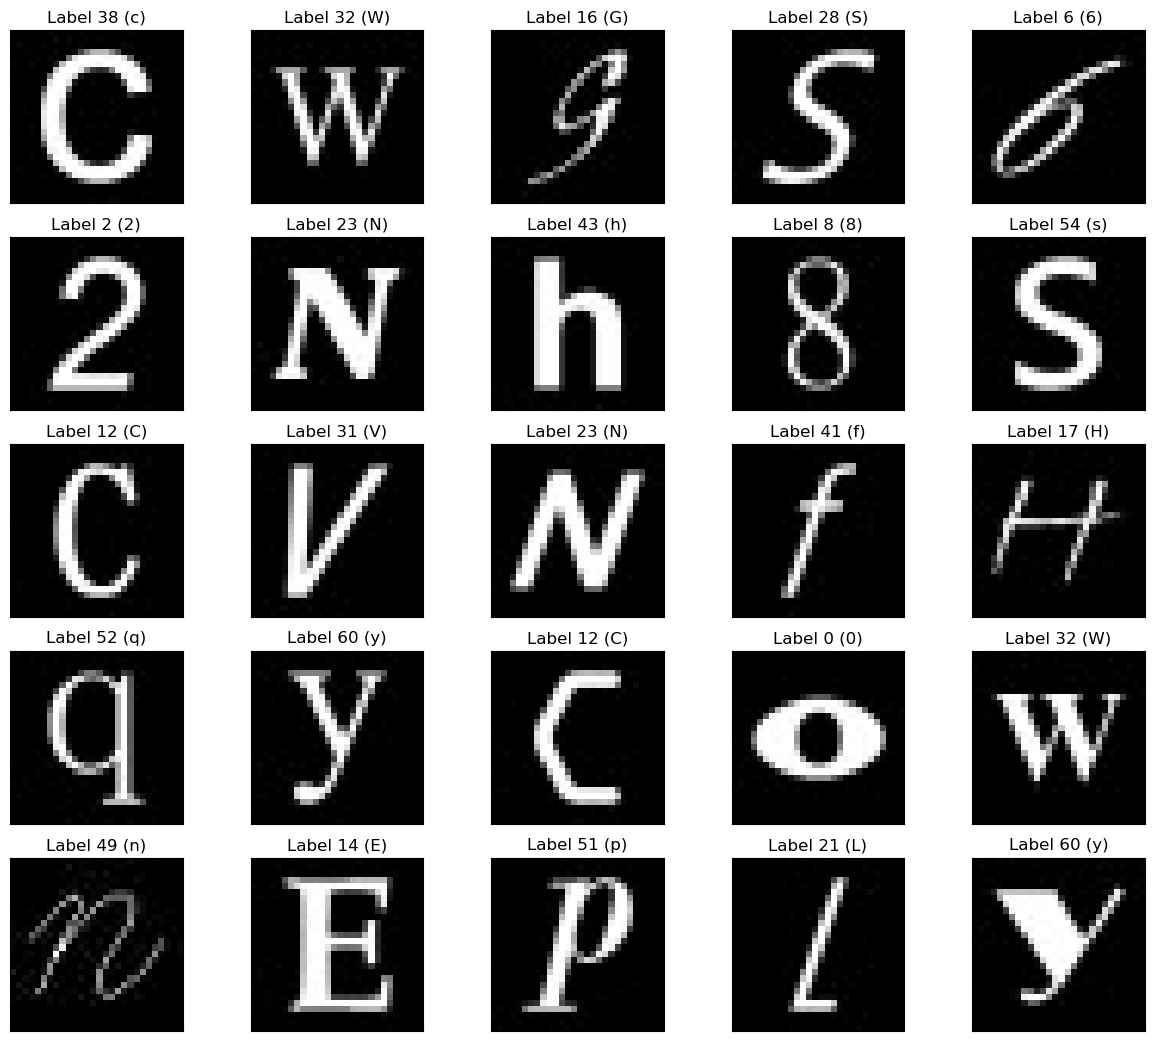

In [4]:
# Visualize random image data
def plot_images(df):
    fig, axes = plt.subplots(5, 5, figsize=(15, 13))
    sample_df = df.sample(n=25)
    label_names = digits + ascii_uppercase + ascii_lowercase
    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_df.iloc[i, 1:].values.reshape(28, 28), cmap='binary')
        label_index = sample_df.iloc[i, 0]
        label_decoded = label_names[label_index]
        ax.set_title(f'Label {label_index} ({label_decoded})')
        ax.set_xticks(()); ax.set_yticks(())
    plt.show()

plot_images(df)

## 3. Create Data for Training dan Validation

In [5]:
# Split data into training and test sets
X = df.drop('label', axis=1).to_numpy()
y = df['label'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Reshape data to 4 dimensions (number of data, height, width, color)
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Resize images to (32, 32, 1)
X_train = tf.image.resize(X_train, [32, 32])
X_test = tf.image.resize(X_test, [32, 32])

# One hot encoding on labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=62)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=62)

# Create data augmentation by inverting image colors
X_train_inverted = 1 - X_train
X_test_inverted = 1 - X_test

# Combine original data with inverted color data
X_train_combined = np.concatenate((X_train, X_train_inverted), axis=0)
X_test_combined = np.concatenate((X_test, X_test_inverted), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)
y_test_combined = np.concatenate((y_test, y_test), axis=0)

# Shuffle or randomize data
train_indices = np.random.permutation(len(X_train_combined))
test_indices = np.random.permutation(len(X_test_combined))

X_train_combined = X_train_combined[train_indices]
y_train_combined = y_train_combined[train_indices]
X_test_combined = X_test_combined[test_indices]
y_test_combined = y_test_combined[test_indices]

## 4. Import Model and Fine Tune with Data

In [ ]:
import_model = tf.keras.models.load_model('model_download/OCR-2U-024.h5')

# Find the layer named 'dense'
layer_name = 'global_average_pooling2d'
layer_output = import_model.get_layer(layer_name).output

# Add a new layer
x = tf.keras.layers.Dropout(0.2)(layer_output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(62, activation='softmax', name='prediction_output')(x)

# Create a new model
model = tf.keras.models.Model(inputs=import_model.input, outputs=x)

# Compile the new model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the new model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 4)    104         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 8)    296         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 8)    0           ['conv2d_1[0][0]']               
                                                                                              

## 5. Model Training and Evaluation

In [ ]:
# Add early stopping if no improvement in validation loss after 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Add learning rate reduction if no improvement in validation loss after 3 epochs
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

history = model.fit(
    X_train_combined,
    y_train_combined,
    validation_data=(X_test_combined, y_test_combined),
    epochs=100,
    callbacks=[early_stopping, lr_schedule])

Epoch 1/100
3544/3544 [==============================] - 85s 21ms/step - loss: 0.6378 - accuracy: 0.7840 - val_loss: 0.5397 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 2/100
3544/3544 [==============================] - 73s 21ms/step - loss: 0.4125 - accuracy: 0.8406 - val_loss: 0.4070 - val_accuracy: 0.8455 - lr: 0.0010
Epoch 3/100
3544/3544 [==============================] - 73s 21ms/step - loss: 0.3596 - accuracy: 0.8569 - val_loss: 0.8138 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 4/100
3544/3544 [==============================] - 73s 20ms/step - loss: 0.3318 - accuracy: 0.8655 - val_loss: 0.4128 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 5/100
3544/3544 [==============================] - 74s 21ms/step - loss: 0.3209 - accuracy: 0.8704 - val_loss: 0.3438 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 6/100
3544/3544 [==============================] - 75s 21ms/step - loss: 0.3072 - accuracy: 0.8751 - val_loss: 0.3781 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 7/100
3544/3544 [=================

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_combined, y_test_combined, verbose=1)
print(f'Test accuracy: {test_acc}')

394/394 [==============================] - 3s 7ms/step - loss: 0.2046 - accuracy: 0.9170
Test accuracy: 0.9169841408729553


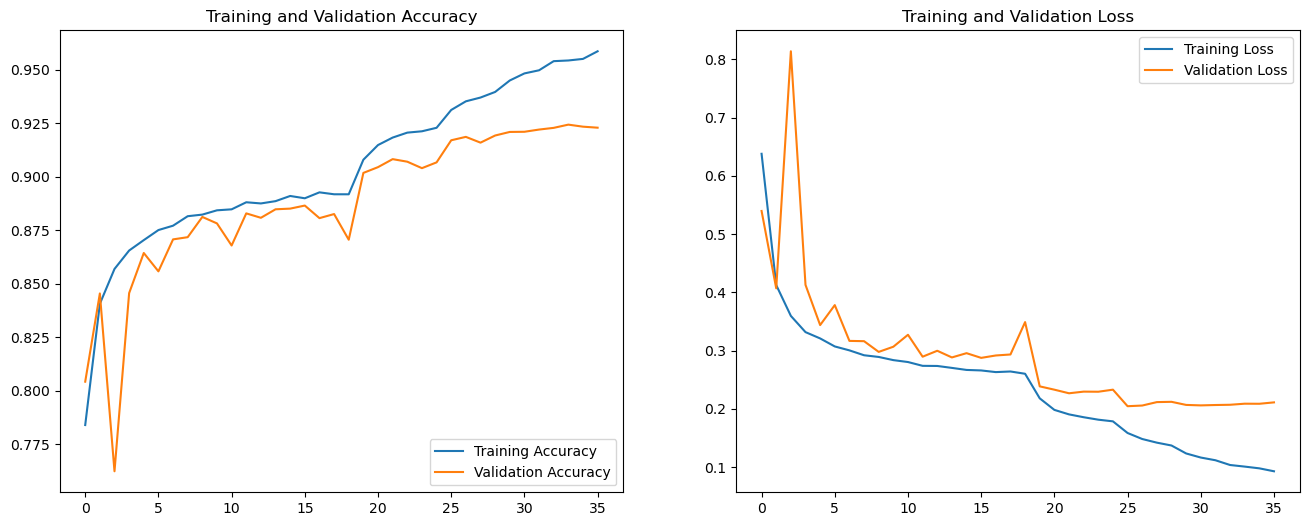

In [9]:
# show loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Character Recognition

In [7]:
labels = digits + ascii_uppercase + ascii_lowercase
labels = [label for label in labels]

FileUpload(value=(), accept='image/*', description='Upload')

1/1 [==============================] - 0s 23ms/step
Predicted Label: F


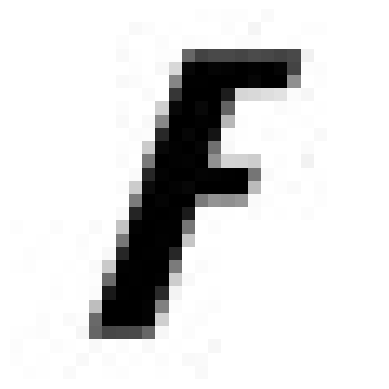

1/1 [==============================] - 0s 24ms/step
Predicted Label: w


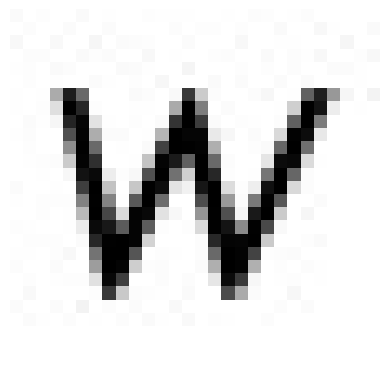

1/1 [==============================] - 0s 24ms/step
Predicted Label: Z


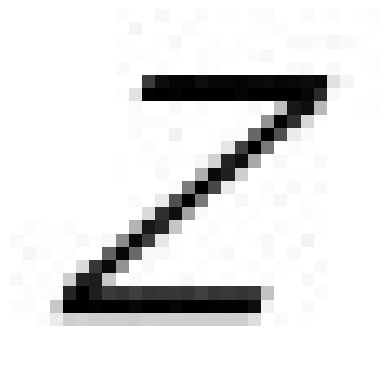

In [ ]:
# predict on single image
def predict_single_image(image_path, model):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    image = tf.image.resize(image, [32, 32])
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_label = labels[np.argmax(prediction)]
    return predicted_label

# Function to handle image upload
def select_image_to_upload(change):
    uploaded_file = change['new']
    if uploaded_file:
        for file_info in uploaded_file:
            file_name = file_info['name']
            with open(file_name, 'wb') as f:
                f.write(file_info['content'])
            predicted_label = predict_single_image(file_name, model)
            print(f'Predicted Label: {predicted_label}')
            img = Image.open(file_name)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()
            os.remove(file_name)

# Create an upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
upload_button.observe(select_image_to_upload, names='value')
display(upload_button)

1/1 [==============================] - 0s 30ms/step
Results:
Character: E (Probability: 0.99)
Character: n (Probability: 1.00)
Character: e (Probability: 0.98)
Character: r (Probability: 1.00)
Character: g (Probability: 1.00)
Character: y (Probability: 1.00)
Character: k (Probability: 0.99)
Character: c (Probability: 0.97)
Character: a (Probability: 1.00)
Character: l (Probability: 0.83)
Detected Text: Energykcal (Average Probability: 0.98)


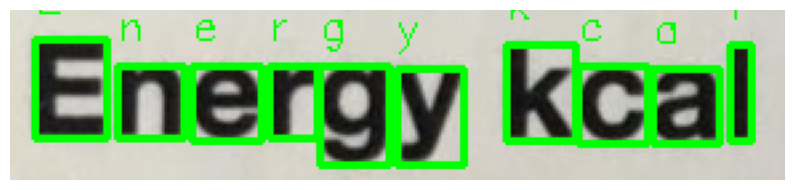

In [ ]:
def non_max_suppression(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return boxes[pick].astype('int')

def process_image(image_path):
    # Read the image
    src = cv2.imread(image_path)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    
    # Detect contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method='left-to-right')[0]
    
    boxes = []
    chars = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if (w >= 5 and w <= 150) and (h >= 20 and h <= 120):
            boxes.append((x, y, w, h))

    # Apply Non-Max Suppression to bounding boxes
    filtered_boxes = non_max_suppression(boxes, overlap_thresh=0.3)

    for (x, y, w, h) in filtered_boxes:
        # Extract ROI
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape

        # Resize and pad
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
        else:
            thresh = imutils.resize(thresh, height=32)
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, 
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))

        # Prepare for prediction
        padded = padded.astype('float32') / 255.0
        padded = np.expand_dims(padded, axis=-1)
        chars.append((padded, (x, y, w, h)))

    if not chars:
        print('No characters detected.')
        return '', src

    # Predict with model
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype='float32')
    preds = model.predict(chars)

    # Interpret prediction results
    results = []
    for pred, (x, y, w, h) in zip(preds, boxes):
        i = np.argmax(pred)
        prob = pred[i]
        label = labels[i]
        results.append((label, prob, (x, y, w, h)))

    # Sort results by x position
    sorted_results = sorted(results, key=lambda x: x[2][0])  # Sort by x (horizontal position)

    detected_text = ''
    total_prob = 0
    print('Results:')
    for label, prob, (x, y, w, h) in sorted_results:
        total_prob += prob
        detected_text += label
        print(f'Character: {label} (Probability: {prob:.2f})')

        # Display bounding box on the original image
        cv2.rectangle(src, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(src, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Calculate average probability
    avg_prob = total_prob / len(preds)
    print(f'Detected Text: {detected_text} (Average Probability: {avg_prob:.2f})')

    return detected_text, avg_prob, src

# Run the function on the input image
image_path = 'input_example/input1.png'
detected_text, avg_prob, result_image = process_image(image_path)

# Display the result image in the notebook
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## 7. Save the Model

In [11]:
# Save the model
model.save("../model/ocr-model/ocr.keras")

## 8. Try to Import Fine Tuned Model (Opsional)

In [12]:
# Try to load the model
model = tf.keras.models.load_model("../model/ocr-model/ocr.keras")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 4)    104         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 8)    296         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 8)    0           ['conv2d_1[0][0]']               
                                                                                              